### [1. Подготовка](#preparation)
* [1.1. Импорт библиотек](#libs)
* [1.2. Вспомогательные функции](#func)
* [1.3. Загрузка тренировочных данных](#load_train)
* [1.4 Загрузка тестовых данных](#load_test)

### [2. EDA](#EDA)
* [2.1. Обзор обучающего датасета](#reveiw)
* [2.2. Анализ признаков](#feature_analysis)
    * [2.2.1 Дискретные признаки](#num_features)
    * [2.2.2 Категориальные признаки](#cat_features)
    * [2.2.3 Оценка линейной корреляции признаков](#check_corr)
    
### [3. Обработка признаков](#feature_processing)
* [3.1. Предварительная обработка](#DataPreprocessing)
* [3.2. Построение новых признаков](#feature_generating)    

### [4. Построение модели](#modeling)
* [4.1. Разбиение на train и test](#train_test) 
* [4.2. Балансировка целевой переменной](#target_balancing) 
* [4.3 Отбор признаков](#feature_selection)
* [4.4. Обучение модели](#learning)
* [4.5. Оценка модели](#evaluation)
* [4.6. Важность признаков](#feature_importance)
* [4.7. Прогнозирование на тестовом датасете](#forecasting)

# 1. Подготовка <a class='anchor' id='preparation'>

## 1.1. Импорт библиотек <a class='anchor' id='libs'>

In [1]:
import numpy as np
import pandas as pd
import random as rnd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

# input
TRAIN_DATASET_PATH = './input/course_project_train.csv'
TEST_DATASET_PATH = './input/course_project_test.csv'

# output
PREP_DATASET_PATH = './output/training_project_data.csv'

## 1.2. Вспомогательные функции <a class='anchor' id='func'>

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [6]:
# Функция получения данных внутри или вне интервала
def feature_filter(df, feature, min_val, max_val, trusted = True, with_sort = False):

    trusted_msk = (df[feature] >= min_val) & (train_df[feature] <= max_val)
    untusted_msk = (df[feature] < min_val) | (train_df[feature] > max_val)
    
    filtered_df = df[trusted_msk if trusted else ~trusted_msk]
        
    if with_sort:
        return filtered_df.sort_values(feature)
    else:
        return filtered_df

In [7]:
def print_untrusted(scales, title):
    #     
    x_scale = scales.index
    y_scale = scales.values
    if not x_scale.empty:
        x_ext = np.std(x_scale)
        y_ext = np.std(y_scale)

        x_min, x_max = scales.index.min() - x_ext, scales.index.max() + x_ext
        y_min, y_max = scales.values.min() - y_ext, scales.values.max() + y_ext
        plt.scatter(x_scale, y_scale)

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.title(title)
        plt.xlabel('Значение')
        plt.ylabel('Частота')
        plt.grid()
        plt.show()

In [8]:
def print_trust_untrust(df, feature, min_val, max_val, bin_count=30):
    #     
    trusted_df = feature_filter(df, feature, min_val, max_val, True)
    untrusted_df = feature_filter(df, feature, min_val, max_val, False)
    x_ext = trusted_df[feature].std() * 0.1
    
    # 
    x_min_trust, x_max_trust = min_val - x_ext, max_val + x_ext
    
    plt.hist(trusted_df[feature], bins=bin_count)
    plt.xlim(x_min_trust, x_max_trust)
    plt.grid()
    
    plt.title('Доверительный интервал')
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.show()
    
    vc = untrusted_df[feature].value_counts()
    if vc[vc.index < min_val] is not None:
        print_untrusted(vc[vc.index < min_val], 'Аномальные значения слева')
    if vc[vc.index > min_val] is not None:
        print_untrusted(vc[vc.index > min_val], 'Аномальные значения справа')

## 1.3. Загрузка тренировочных данных <a class='anchor' id='load_train'>

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


## 1.4. Загрузка тестовых данных <a class='anchor' id='load_test'>

In [10]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


* [2.1.Обзор обучающего датасета](#reveiw)
* [2.2. Анализ признаков](#feature_analysis)
    * [2.2.1 Дискретные признаки](#num_features)
    * [2.2.2 Категориальные признаки](#cat_features)
    * [2.2.3 Оценка линейной корреляции признаков](#check_corr)

## 2.1. Обзор обучающего датасета <a class='anchor' id='reveiw'>

## Описание датасета

1. **Home Ownership** - домовладение
1. **Annual Income** - годовой доход
1. **Years in current job** - количество лет на текущем месте работы
1. **Tax Liens** - налоговые обременения
1. **Number of Open Accounts** - количество открытых счетов
1. **Years of Credit History** - количество лет кредитной истории
1. **Maximum Open Credit** - наибольший открытый кредит
1. **Number of Credit Problems** - количество проблем с кредитом
1. **Months since last delinquent** - количество месяцев с последней просрочки платежа
1. **Bankruptcies** - банкротства
1. **Purpose** - цель кредита
1. **Term** - срок кредита
1. **Current Loan Amount** - текущая сумма кредита
1. **Current Credit Balance** - текущий кредитный баланс
1. **Monthly Debt** - ежемесячный долг
1. **Credit Score** - ежемесячный долг
1. **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [11]:
train_df.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

In [12]:
# Смотрим количество строк в датасетах
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


## 2.2. Анализ признаков <a class='anchor' id='feature_analysis'>

In [13]:
# проверяем в каких фичах есть пропуски
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [14]:
# разделяем признаки на числовые и категориальные
num_features = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
                'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
                'Current Credit Balance', 'Monthly Debt', 'Credit Score']
# год постройки отнесем к категшориальным признакам так как нет прямой зависимости между годом постройки и ценой
cat_features = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

# смотрим статистику по столбцам
train_df.describe() 

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130934,18.317467,9.451538e+05,0.170000,34.692600,0.117152,11873178.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688807,0.347192,31926124.0,3.178714e+05,11926.764648,1604.451416,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.000000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.000000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


### 2.2.1 Дискретные признаки <a class='anchor' id='num_features'>

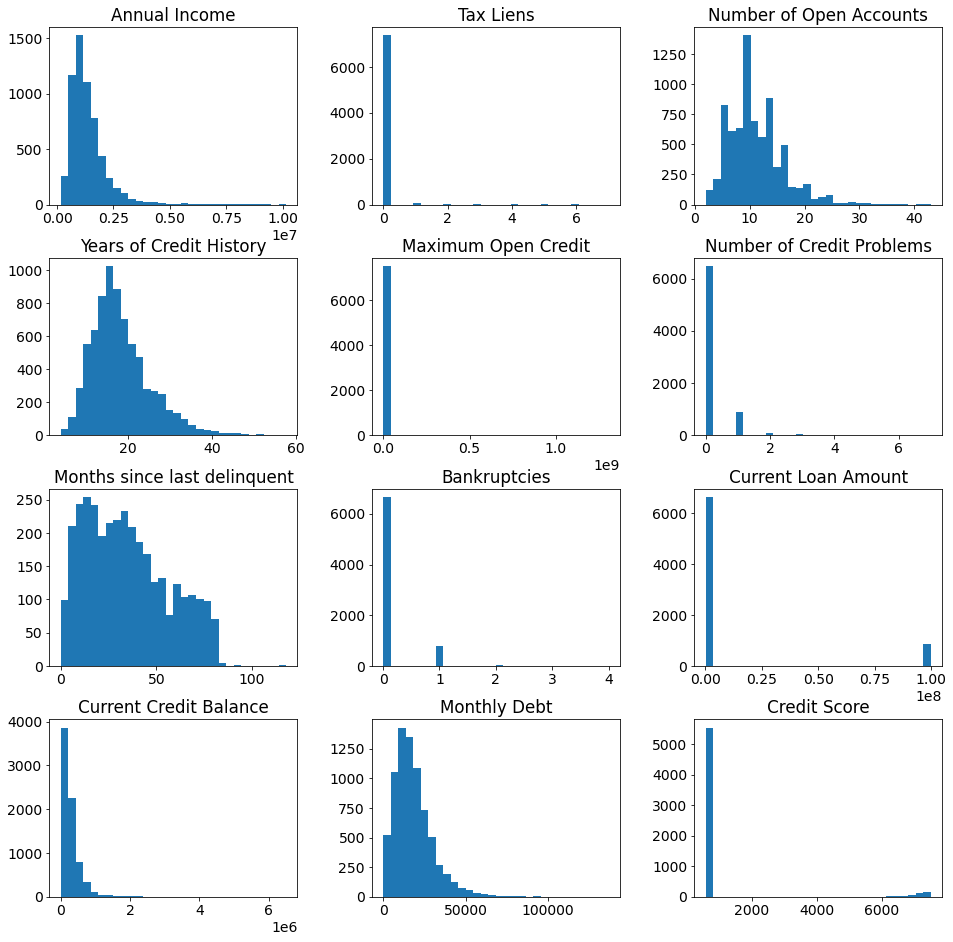

In [15]:
# строим гистограммы по распределению каждой фичи
df_num_features = train_df[num_features]
df_num_features.hist(figsize=(16, 16), bins=30, grid=False);

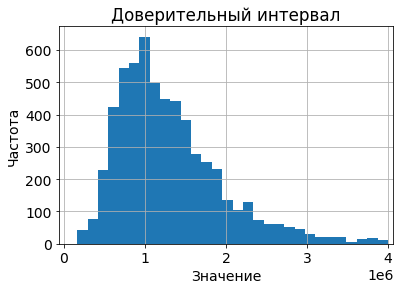

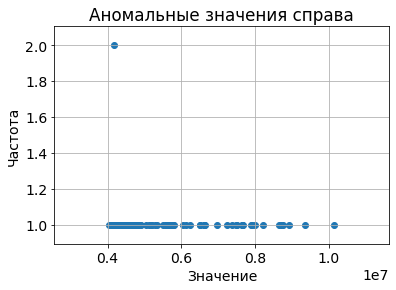

In [16]:
print_trust_untrust(train_df, 'Annual Income', 0, 4e6)

<AxesSubplot:>

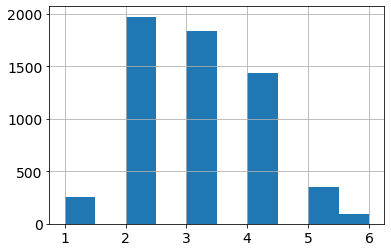

In [17]:
Annual_Income = pd.Series(pd.cut(train_df['Annual Income'],
                                bins = [0, 5e5, 10e5, 15e5, 25e5, 40e5, np.inf], 
                                labels = [1, 2, 3, 4, 5, 6],
                                include_lowest = True,
                                right=False))
Annual_Income.hist()

In [18]:
Tax_problems = pd.Series(pd.cut(train_df['Tax Liens'],
                                bins = [0, 1, np.inf], 
                                labels = [1, 2],
                                include_lowest = True,
                                right=False))
Tax_problems.value_counts()

1    7366
2     134
Name: Tax Liens, dtype: int64

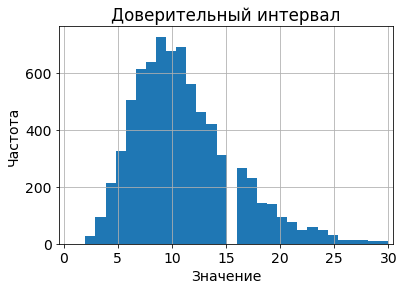

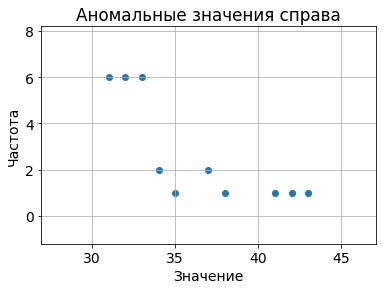

In [19]:
train_df['Number of Open Accounts'].describe()   
print_trust_untrust(train_df, 'Number of Open Accounts', 0, 30)

In [20]:
train_df.groupby(train_df['Years of Credit History']//10).size()

Years of Credit History
0.0     590
1.0    4403
2.0    1982
3.0     441
4.0      75
5.0       9
dtype: int64

In [21]:
Maximum_Open_Credit_cat = pd.Series(pd.cut(train_df['Maximum Open Credit'], 
                                           bins = [0, 1e6, 5e6, 50e6, np.inf], 
                                           labels = [1, 2, 3, 4],
                                           right=False)).astype(np.int8)
Maximum_Open_Credit_cat.value_counts()

1    6310
2    1138
3      48
4       4
Name: Maximum Open Credit, dtype: int64

In [22]:
Number_of_Credit_Problems_cat = pd.Series(pd.cut(train_df['Number of Credit Problems'], 
                                             bins = [0, 1, 3, 5, np.inf], 
                                             labels = [1, 2, 3, 4],
                                             include_lowest = True,
                                             right=False))
Number_of_Credit_Problems_cat.value_counts()

1    6469
2     975
3      44
4      12
Name: Number of Credit Problems, dtype: int64

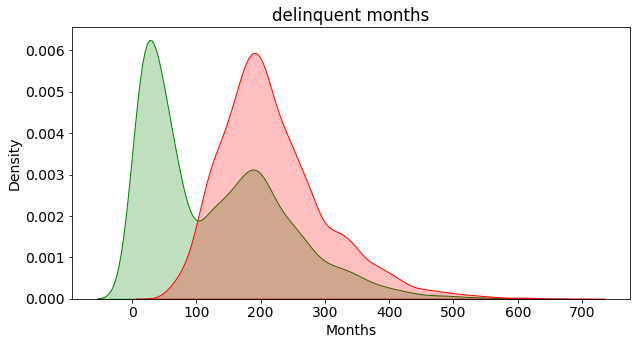

In [23]:
Months_of_Credit_History = train_df['Years of Credit History'] * 12 
Months_without_delinquent = train_df['Months since last delinquent'].combine_first(Months_of_Credit_History)

plt.figure(figsize=(10, 5))

sns.kdeplot(Months_without_delinquent, shade=True, label='No default', color='g')
sns.kdeplot(Months_of_Credit_History, shade=True, label='Default', color='r')

plt.xlabel('Months')
plt.title('delinquent months')
plt.show()

In [24]:
train_df.loc[train_df['Years of Credit History'] * 12 < Months_without_delinquent]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [25]:
train_df[['Bankruptcies', 'Number of Credit Problems']].corr()

,Bankruptcies,Number of Credit Problems
Bankruptcies,1.000000,0.730751
Number of Credit Problems,0.730751,1.000000


In [26]:
train_df.loc[train_df['Current Loan Amount'] == 100000000]
train_df['Current Loan Amount'].value_counts().sort_index(ascending=False)

100000000.0    870
789030.0         1
788942.0         1
788788.0         1
788634.0         2
              ... 
21582.0          1
21560.0          1
21516.0          1
21472.0          2
11242.0          1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [27]:
Current_Credit_Balance_cat = pd.Series(pd.cut(train_df['Current Credit Balance'], 
                                             bins = [0, 1e5, 3e5, 5e5, np.inf], 
                                             labels = [1, 2, 3, 4],
                                             include_lowest = True,
                                             right=False))
Current_Credit_Balance_cat.value_counts()

2    3454
1    1568
3    1412
4    1066
Name: Current Credit Balance, dtype: int64

In [28]:
train_df['Monthly Debt'].value_counts().sort_index()

0.0         6
17.0        1
21.0        1
42.0        1
57.0        1
           ..
96177.0     1
100091.0    1
104036.0    1
110311.0    1
136679.0    1
Name: Monthly Debt, Length: 6716, dtype: int64

In [29]:
train_df.loc[train_df['Monthly Debt'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,66.0,0.0,home improvements,Short Term,75350.0,0.0,0.0,704.0,0
1643,Rent,NaN,9 years,0.0,3.0,10.0,0.0,0.0,NaN,0.0,other,Short Term,332156.0,0.0,0.0,NaN,1
3219,Home Mortgage,NaN,10+ years,0.0,3.0,18.5,0.0,0.0,NaN,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,NaN,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0
4165,Rent,1254513.0,10+ years,0.0,6.0,23.4,0.0,0.0,60.0,0.0,take a trip,Short Term,100000000.0,0.0,0.0,748.0,0
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0


In [30]:
train_df.loc[train_df['Monthly Debt'] > train_df['Current Loan Amount']]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.400000,380052288.0,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
548,Home Mortgage,NaN,10+ years,0.0,18.0,14.100000,1348556.0,0.0,NaN,0.0,other,Short Term,55484.0,823422.0,66848.0,NaN,0
2688,Home Mortgage,1822423.0,8 years,0.0,8.0,24.600000,972224.0,0.0,46.0,0.0,major purchase,Short Term,21714.0,851409.0,41764.0,714.0,0
2721,Rent,3120180.0,10+ years,0.0,24.0,21.500000,1024584.0,0.0,24.0,0.0,debt consolidation,Short Term,30118.0,430046.0,41863.0,705.0,0
4863,Home Mortgage,1381110.0,6 years,0.0,19.0,21.299999,618464.0,0.0,NaN,0.0,medical bills,Short Term,21604.0,392597.0,26966.0,719.0,1
5317,Have Mortgage,980685.0,10+ years,0.0,12.0,36.500000,260392.0,2.0,40.0,1.0,take a trip,Short Term,21846.0,68362.0,24109.0,721.0,0


In [31]:
train_df['Credit Score'].value_counts().sort_index()

585.0     1
586.0     1
588.0     1
589.0     1
590.0     1
         ..
7470.0    4
7480.0    6
7490.0    2
7500.0    2
7510.0    2
Name: Credit Score, Length: 268, dtype: int64

<AxesSubplot:>

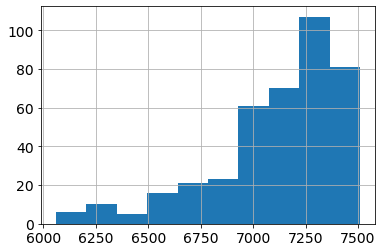

In [32]:
mask = (train_df['Credit Score'] < 850) & (train_df['Credit Score'].notnull())

train_df.loc[~(mask)]['Credit Score'].hist()

In [33]:
Credit_Score = train_df.loc[mask]['Credit Score']
Credit_Score_cat = pd.Series(pd.cut(Credit_Score,
                                    bins = [300, 550, 600, 650, 700, 800, 851],
                                    labels = [1, 2, 3, 4, 5, 6],
                                    include_lowest = True,
                                    right=False))
Credit_Score_cat.value_counts()

5    4541
4     842
3     146
2      14
1       0
6       0
Name: Credit Score, dtype: int64

### 2.2.2 Категориальные признаки <a class='anchor' id='cat_features'>

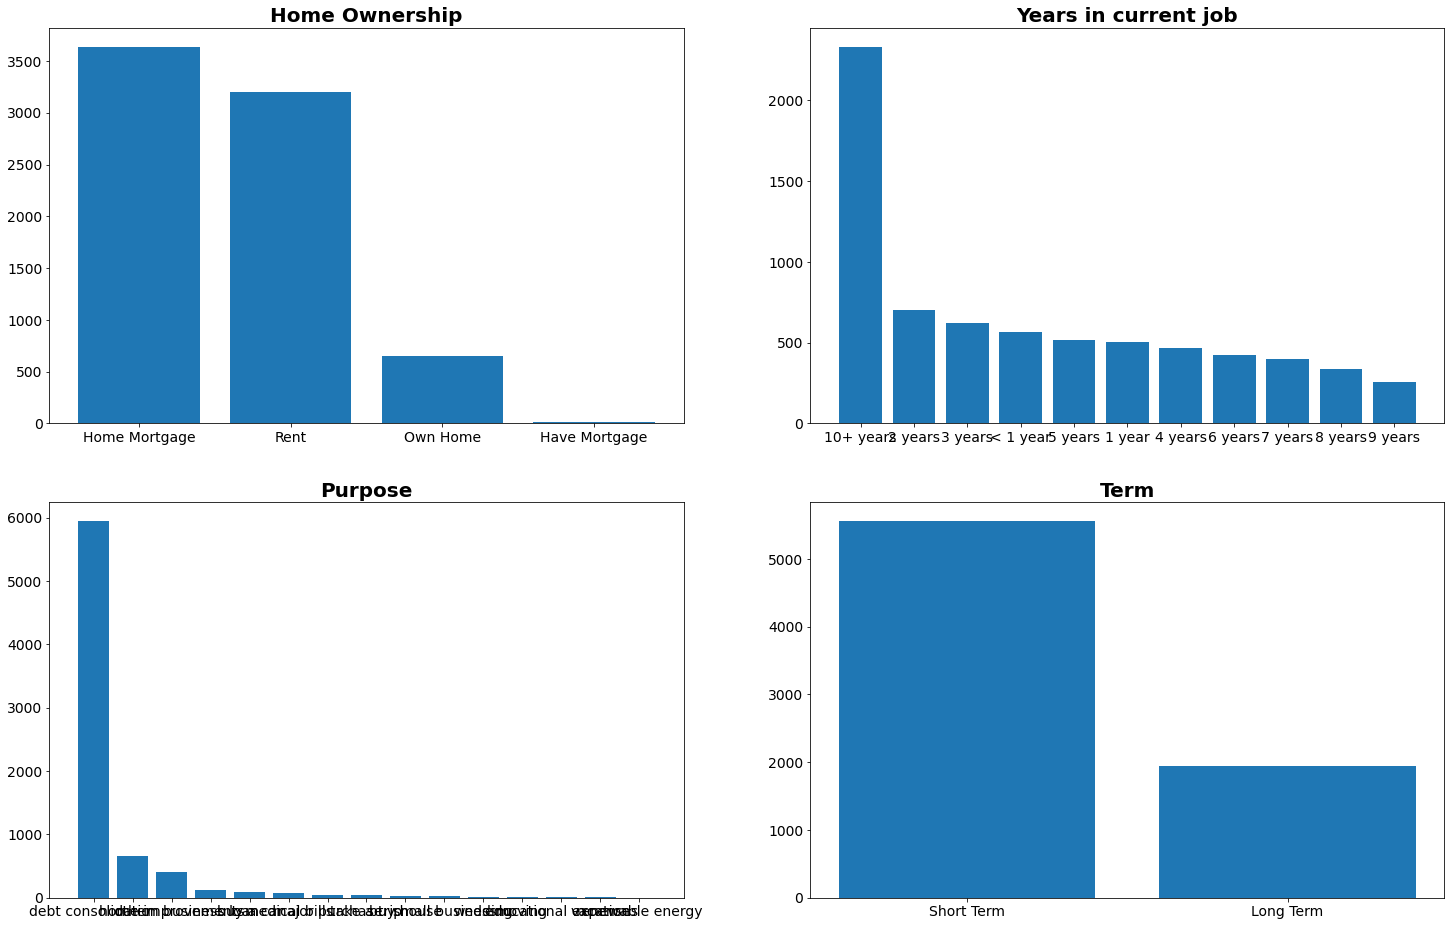

In [34]:
# задаем количество строк b столбцов
col_count = 2
row_count = len(cat_features) // col_count 


# задаем сетку
fig, ax = plt.subplots(nrows=row_count, ncols=col_count, figsize=(25, 16))
axes = ax.flatten()

# построим для каждого признака ящик с усами
for i, feature in enumerate(cat_features, 0):
    cur_ax = axes[i]
    counts = train_df[feature].value_counts()
    cur_ax.bar(counts.index, counts.values)
    cur_ax.set_title(feature, fontweight="bold", size=20) # Title
   
plt.show()

In [35]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

### 2.2.4 Оценка линейной корреляции признаков <a class='anchor' id='check_corr'>

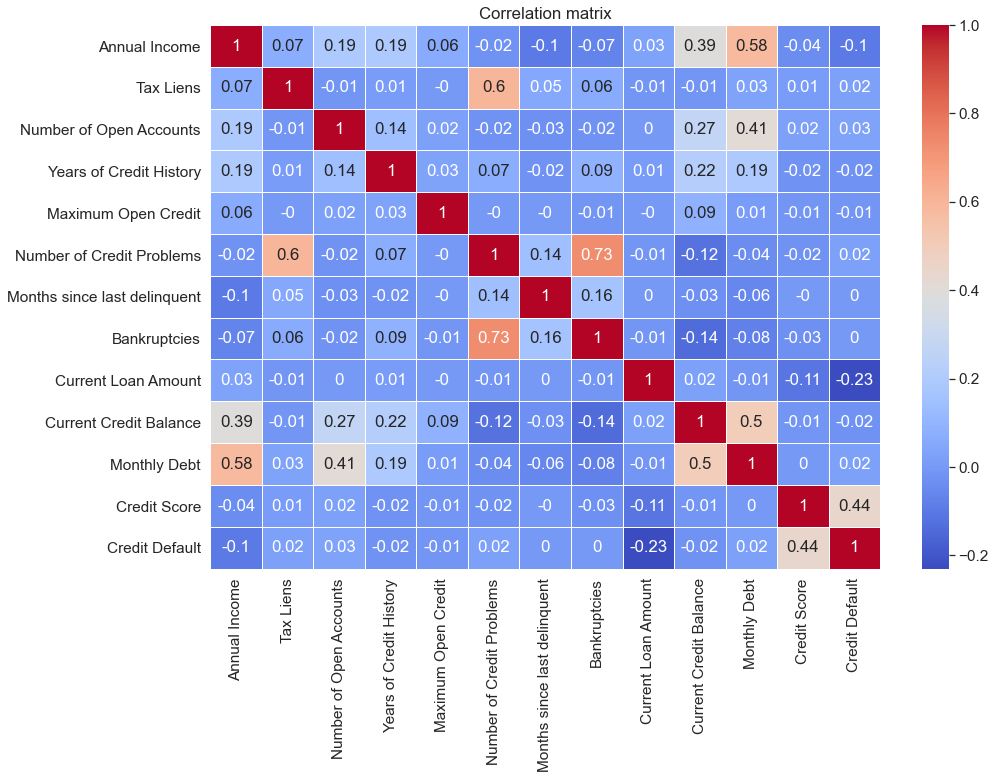

In [36]:
corr_matrix = train_df.corr()

plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# 3 Обработка признаков <a class='anchor' id='feature_processing'>

* [3.1. Предварительная обработка](#DataPreprocessing)
* [3.2. Построение новых признаков](#feature_generating)

## 3.1 Предварительная обработка <a class='anchor' id='DataPreprocessing'>

In [37]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    extrs = {'Annual Income': (0, 4e6),
             'Number of Open Accounts': (1, 30),
             'Maximum Open Credit': (0, 50e6),
             'Current Loan Amount': (0, 1e8),
             'Credit Score': (300, 850)
            }

    def __init__(self):
        """Параметры класса"""

        self.id_maker = LabelEncoder()
        self.years_in_current_job_cat = None
        self.home_ownership_cat = None
        self.purpose_cat = None
        self.term = None
        self.clean_cs_med = None
        self.medians = None
        self.earnings_groups = None
        self.b_problems = None
        
        
    def fit(self, X):
        """Сохранение статистик"""    
        # Расчет медиан
        self.medians = X.median()
        self.years_in_current_job_cat = X.loc[X['Years in current job'].notnull(), 'Years in current job']. \
                                        cat.categories.to_list()
        self.home_ownership_cat = X.loc[X['Home Ownership'].notnull(), 'Home Ownership'].cat.categories.to_list()
        self.purpose_cat = X.loc[X['Purpose'].notnull(), 'Purpose'].cat.categories.to_list()
        self.term = X.loc[X['Term'].notnull(), 'Term'].cat.categories.to_list()
        
        clean_cs_msk = (X['Credit Score'].notnull()) & (X['Credit Score'].between(*self.extrs['Credit Score']))
        self.clean_cs_med = X.loc[clean_cs_msk, 'Credit Score'].median()
        
        
        Annual_Income = X['Annual Income'].copy()
        Annual_Income.fillna(-1)
        Annual_Income_cat = pd.Series(pd.cut(Annual_Income,
                                             bins = [-1, 0, 5e5, 10e5, 15e5, 25e5, 40e5, np.inf], 
                                             labels = [0, 1, 2, 3, 4, 5, 6],
                                             include_lowest = True,
                                             right=False), name='Annual_Income_cat')
        
        
        income_df = pd.concat([X['Annual Income'], Annual_Income_cat], axis=1)
        self.earnings_groups = income_df.groupby(['Annual_Income_cat'], as_index=False).agg({'Annual Income':'median'})
        self.earnings_groups.rename(columns={'Annual Income':'Annual_Income_Group_Med'}, inplace=True)

        self.b_problems = X.loc[X['Bankruptcies'].notnull(), ['Bankruptcies', 'Number of Credit Problems']]
        
    def transform(self, X):
        """Трансформация данных"""
        
        X = X.copy()
        
        # создаем доп признаки для выбросных признаков
        outlier_sfx = ' outlier'
        for feature in self.extrs.keys():
            feature_outlier = feature + outlier_sfx
            X[feature_outlier] = 0
            f_min, f_max = self.extrs[feature]
            outliner_mask = (X[feature] < f_min) | (X[feature] > f_max)
            X.loc[outliner_mask, feature_outlier] = 1
            if feature != 'Credit Score':
                X.loc[outliner_mask, feature] = self.medians[feature]
                X[feature].fillna(self.medians[feature], inplace=True)
            else:
                low_cs_msk = X['Credit Score'] < f_min 
                hight_cs_msk = X['Credit Score'].between(f_min * 10, f_max * 10)
                dirty_cs_msk = (X['Credit Score'].between(f_max, f_min*10)) | \
                               (X['Credit Score'] > f_max * 10) | \
                               (X['Credit Score'].isnull())
                
                X.loc[low_cs_msk, 'Credit Score'] = f_min
                X.loc[hight_cs_msk, 'Credit Score'] = X['Credit Score'] / 10
                X.loc[dirty_cs_msk, 'Credit Score'] = self.clean_cs_med

        X['Annual_Income_cat'] = pd.Series(pd.cut(X['Annual Income'],
                                                  bins = [-1, 0, 5e5, 10e5, 15e5, 25e5, 40e5, np.inf], 
                                                  labels = [0, 1, 2, 3, 4, 5, 6],
                                                  include_lowest = True,
                                                  right=False))

        monthly_debt_err_msk = (X['Monthly Debt'] > X['Current Loan Amount']) | (X['Monthly Debt'] == 0)
        X['Monthly Debt outlier'] = 0
        X.loc[monthly_debt_err_msk, 'Monthly Debt outlier'] = 1
        
        X = X.merge(self.earnings_groups, on='Annual_Income_cat', how='left')
        X.loc[monthly_debt_err_msk, 'Monthly Debt'] = \
            X[['Current Loan Amount', 'Annual_Income_Group_Med']].min(axis=1)
        
        text_features = ['Years in current job', 'Home Ownership', 'Purpose', 'Term']
        for feature in text_features:
            X[feature] = self.id_maker.fit_transform(X[feature])
        
        X['Bankruptcies outlier'] = 0
        X.loc[X['Bankruptcies'].isnull() , 'Bankruptcies outlier'] = 1
        X['Bankruptcies'].fillna(self.b_problems.sample(n=1, weights='Number of Credit Problems')['Bankruptcies'].array[0], inplace=True)
        
        return X

In [38]:
train_df2 = train_df.copy()
test_df2 = test_df.copy()

In [39]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

train_df.shape, test_df.shape

((7500, 26), (2500, 25))

## 3.2. Построение новых признаков <a class='anchor' id='feature_generating'>

In [40]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.loan_amount_quan = None
        
    def fit(self, X, y=None):
        
        self.loan_amount_quan = X.loc[X['Current Loan Amount'] < 1e8, 'Current Loan Amount']. \
                                 quantile([.0, .25, .5, .75, .90, 1]).to_list()
        self.loan_amount_quan.append(1e8)

    def transform(self, X):
        
        X['Netto_income'] = X['Annual Income'] * (1 - X['Tax Liens'] / (X['Tax Liens'] + 100))
        X['Total_credit_amount'] = X['Current Credit Balance'] + X['Current Loan Amount']
        X['Tax problems'] = 0
        X.loc[X['Tax Liens'] > 0, 'Tax problems'] = 1
        X['Decades of Credit History'] = X['Years of Credit History'] // 10
        X['Pensioner'] = 0
        X.loc[X['Years of Credit History'] > 40,'Pensioner'] = 1
        
        X['Maximum Open Credit Cat'] = pd.Series(pd.cut(X['Maximum Open Credit'], 
                                                        bins = [0, 1e6, 5e6, 50e6, np.inf], 
                                                        labels = [1, 2, 3, 4],
                                                        right=False)).astype(np.int8)
         
        X['Number of Credit Problems'] = pd.Series(pd.cut(X['Number of Credit Problems'], 
                                                          bins = [0, 1, 3, 5, np.inf], 
                                                          labels = [1, 2, 3, 4],
                                                          include_lowest = True,
                                                          right=False))
        
        X['Current Credit Balance cat'] = pd.Series(pd.cut(X['Current Credit Balance'], 
                                                           bins = [0, 1e5, 3e5, 5e5, np.inf], 
                                                           labels = [1, 2, 3, 4],
                                                           include_lowest = True,
                                                           right=False))
        
        X['has delinquent'] = 0
        X.loc[X['Months since last delinquent'].notnull(), 'has delinquent'] = 1
        
        X['Months without last delinquent'] = X['Months since last delinquent'].combine_first(
            X['Years of Credit History'] * 12 )
        
        X['Credit Score cat'] = pd.Series(pd.cut(X['Credit Score'],
                                                 bins = [300, 550, 600, 650, 700, 800, 851],
                                                 labels = [1, 2, 3, 4, 5, 6],
                                                 include_lowest = True,
                                                 right=False))
        
        X['Month to debt repayment'] = X['Current Loan Amount'] // X['Monthly Debt']

        X['Current Loan Amount cat'] = pd.Series(pd.cut(X['Current Loan Amount'],
                                                        bins = self.loan_amount_quan,
                                                        labels = [1, 2, 3, 4, 5, -1],
                                                        include_lowest = True,
                                                        right=True))
        
        X['close_to_default'] = 0
        X.loc[X['Months since last delinquent'] <= 1, 'close_to_default'] = 1
        
        X['At Risk'] = (X['Pensioner'] == 1).astype(int) + \
                       (X['Home Ownership'] == 1).astype(int) + \
                       (X['Current Loan Amount cat'] <= 2).astype(int) + \
                       (X['Years in current job'].isin([0, 2, 3, 10, 11])).astype(int) + \
                       (X['Bankruptcies'] > 1).astype(int) + \
                       (X['Tax Liens'] > 2).astype(int) + \
                       (X['has delinquent'] == 1).astype(int)
        
        cat_features = ['Tax problems', 'Pensioner', 'Maximum Open Credit Cat', 'has delinquent', 
                        'Home Ownership', 'Bankruptcies outlier', 'Annual Income outlier', 'close_to_default',
                        'Number of Open Accounts outlier', 'Maximum Open Credit outlier', 'Current Loan Amount outlier',
                        'Credit Score outlier', 'Monthly Debt outlier', 'Purpose', 'Term', 'Years in current job']
        
        for feature in cat_features:
            X[feature] = X[feature].astype('category')
        
        return X

In [41]:
features_gen = FeatureGenetator()
features_gen.fit(train_df)

In [42]:
train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)

train_df.shape, test_df.shape

((7500, 40), (2500, 39))

# 4. Построение модели <a class='anchor' id='modeling'>

* [4.1. Разбиение на train и test](#train_test) 
* [4.2. Балансировка целевой переменной](#target_balancing) 
* [4.3 Отбор признаков](#feature_selection)
* [4.4. Обучение модели](#learning)
* [4.5. Оценка модели](#evaluation)
* [4.6. Важность признаков](#feature_importance)
* [4.7. Прогнозирование на тестовом датасете](#forecasting)

In [43]:
num_feature_names = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                     'Monthly Debt', 'Netto_income', 'Total_credit_amount',  'Decades of Credit History',
                     'Months without last delinquent', 'Month to debt repayment', 'At Risk', 'Credit Score']

cat_feature_names = ['Credit Score cat', 'Current Loan Amount cat', 'Annual_Income_cat', 'Number of Credit Problems', 
                     'Current Credit Balance cat', 'Purpose', 'Term', 'Years in current job', 'Tax problems', 'Pensioner', 
                     'Maximum Open Credit Cat', 'has delinquent',  'Home Ownership', 'Bankruptcies outlier',
                     'Annual Income outlier', 'Number of Open Accounts outlier', 'Maximum Open Credit outlier', 
                     'Current Loan Amount outlier', 'Credit Score outlier', 'Monthly Debt outlier', 'close_to_default']

target_name = 'Credit Default'

## 4.1. Разбиение на train и test <a class='anchor' id='train_test'>

In [44]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)

## 4.2. Балансировка целевой переменной <a class='anchor' id='target_balancing'>

In [45]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    4290
1    3420
Name: Credit Default, dtype: int64

In [46]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

In [47]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_valid, y_valid], axis=1)

## 4.3 Отбор признаков <a class='anchor' id='feature_selection'>

In [48]:
X_train_lg = X_train[num_feature_names + cat_feature_names]
X_valid_lg = X_valid[num_feature_names + cat_feature_names]
test_df_lg = test_df[num_feature_names + cat_feature_names]

## 4.4. Обучение модели <a class='anchor' id='learning'>

In [49]:
general_cat_features_xgb = num_feature_names + cat_feature_names

# general_cat_features_xgb = ['Credit Score outlier',
#  'Current Loan Amount',
#  'Total_credit_amount',
#  'Term',
#  'Credit Score',
#  'Month to debt repayment',
#  'Netto_income',
#  'Annual Income',
#  'Years in current job',
#  'Maximum Open Credit',
#  'Monthly Debt',
#  'Current Loan Amount cat',
#  'Home Ownership',
#  'Number of Open Accounts',
#  'Maximum Open Credit outlier']

X_train_xgb = X_train[general_cat_features_xgb]
X_valid_xgb = X_valid[general_cat_features_xgb]
test_df_xgb = test_df[general_cat_features_xgb]

cat_feature_names_xgb = X_train_xgb.select_dtypes(exclude=["number","bool_","object_"]).columns

In [50]:
for feature in cat_feature_names_xgb:
    X_train_xgb = X_train_xgb.astype({feature: 'int64'})
    X_valid_xgb = X_valid_xgb.astype({feature: 'int64'})
    test_df_xgb = test_df_xgb.astype({feature: 'int64'})

In [51]:
params = {'n_estimators': 100,
          'min_child_weight': 50,
          'max_depth': 3,
          'scale_pos_weight':1.1,
          'gamma': 10,
          'eta': 0.11,
          'lambda' : 1.1,
          'alpha': 10,
          'objective': 'binary:logistic',
          'max_leaves': 2,
          'eval_metric': 'mlogloss',
          'random_state':21}

model_xgb = xgb.XGBClassifier(**params)
model_xgb.fit(X_train_xgb, y_train)

y_train_pred = model_xgb.predict(X_train_xgb)
y_test_pred = model_xgb.predict(X_valid_xgb)
y_test_pred_probs_xgb = model_xgb.predict_proba(X_valid_xgb)

## 4.5. Оценка модели <a class='anchor' id='evaluation'>

In [52]:
get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.83      0.76      4290
           1       0.72      0.54      0.62      3420

    accuracy                           0.70      7710
   macro avg       0.71      0.69      0.69      7710
weighted avg       0.70      0.70      0.69      7710

TEST

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1097
           1       0.52      0.54      0.53       403

    accuracy                           0.74      1500
   macro avg       0.67      0.68      0.67      1500
weighted avg       0.74      0.74      0.74      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               896  201
1               187  216


## 4.6. Важность признаков <a class='anchor' id='feature_importance'>

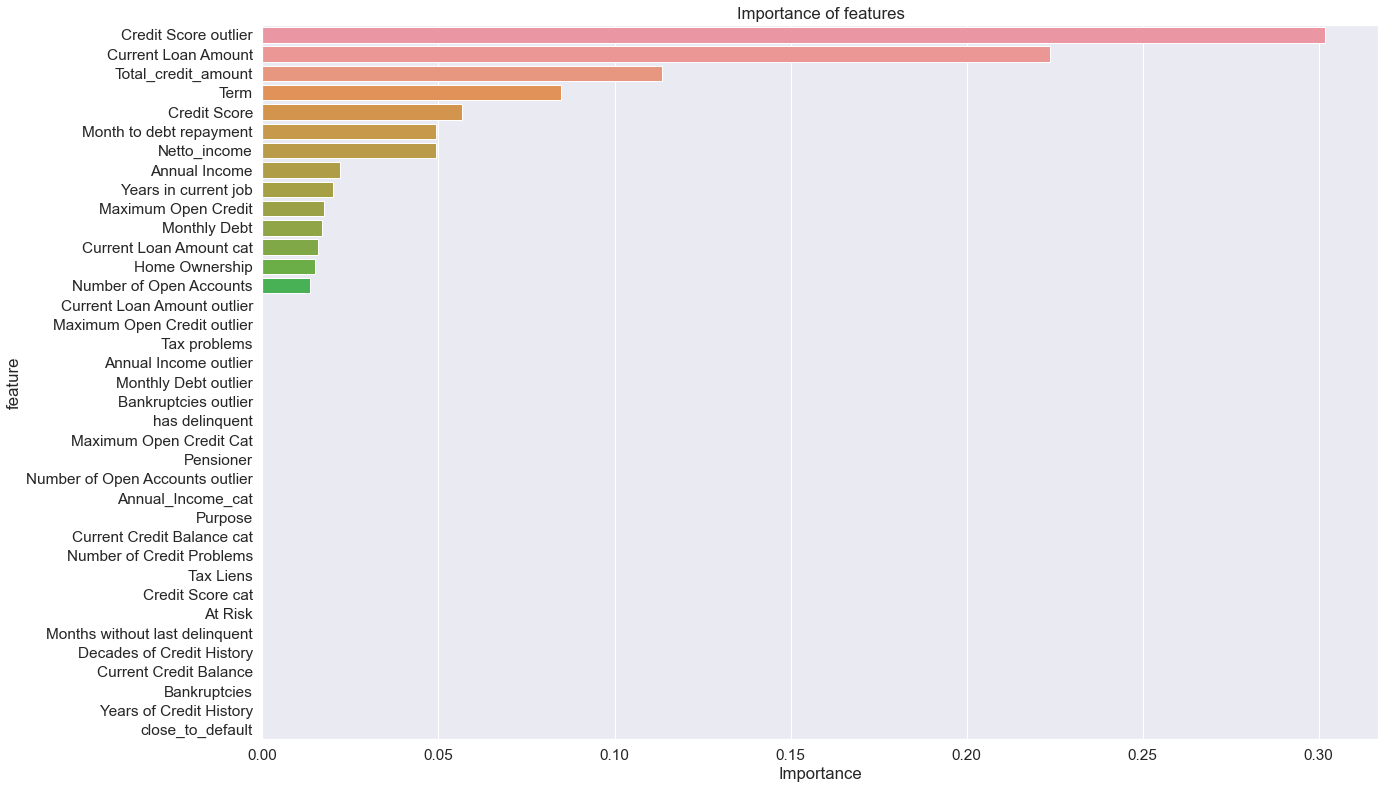

['Credit Score outlier',
 'Current Loan Amount',
 'Total_credit_amount',
 'Term',
 'Credit Score',
 'Month to debt repayment',
 'Netto_income',
 'Annual Income',
 'Years in current job',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Loan Amount cat',
 'Home Ownership',
 'Number of Open Accounts',
 'Current Loan Amount outlier']

In [53]:
important_features_top = show_feature_importances(X_train_xgb.columns, model_xgb.feature_importances_, get_top=15)
important_features_top

## 4.7. Прогнозирование на тестовом датасете <a class='anchor' id='forecasting'>

In [54]:
y_test_df_pred = model_xgb.predict(test_df_lg)

preds_final = pd.DataFrame()
preds_final = pd.DataFrame({'Id': np.arange(0,y_test_df_pred.shape[0]), 'Credit Default': y_test_df_pred})

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

submit = pd.read_csv(PREP_DATASET_PATH)
submit['Credit Default'] = preds_final['Credit Default']
submit.to_csv(PREP_DATASET_PATH, index=False)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.83      0.76      4290
           1       0.72      0.54      0.62      3420

    accuracy                           0.70      7710
   macro avg       0.71      0.69      0.69      7710
weighted avg       0.70      0.70      0.69      7710

TEST

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1097
           1       0.52      0.54      0.53       403

    accuracy                           0.74      1500
   macro avg       0.67      0.68      0.67      1500
weighted avg       0.74      0.74      0.74      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               896  201
1               187  216


In [55]:
preds_final['Credit Default'].value_counts()

0    1832
1     668
Name: Credit Default, dtype: int64